# Implementation of Text Level Graph Neural Network for Text Classification
Here, I am implementing a research paper titled <i>Text Level Graph Neural Network for Text Classification</i> which can be found [here](https://arxiv.org/pdf/1910.02356.pdf). Previous GNN-based methods of text classification involved creating a single graph for the entire corpus, which caused two major problems. First, this results in high memory consumption and is impractical for larger graphs. Second, it is very difficult to apply these models to new data, because the structure and parameters of the graph is dependent on the corpus and cannot be modified after training.

This paper tackles these problems by building graphs for each input text rather than a single graph for the entire corpus. The representations and edge weights of the same node are shared globally and are updated through a message passing mechanism where a node uses information from neighboring nodes to update its representation. Additionally, the word nodes in the graph are connected within a reasonably small window in the text rather than fully connecting all word nodes. Predictions are made by summarizing the representations of all the nodes in the graph.

## Practical Use-Cases
<ul>
        <li> spam detection
        <li> fake news detection
        <li> tagging content or products by using categories as a way to improve browsing or identify related content on the website. This can be used in ecommerce and with news agencies, content curators, blogs, and directories
        <li> a faster emergency response system can be made by classifying panic conversation on social media
        <li> marketers can monitor and classify users based on how they talk about a product or brand online
        <li> academia, law practitioners, social researchers, government, and non-profit organizations deal with a lot of unstructured text, handling the data would be much easier if it were standardized by categories/tags
        <li> sentiment analysis
        <li> organizations need to classify documents so that their text data is easier to manage and utilize such as classifying incoming customer support tickets so they get sent to the right customer
            
</ul>


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from time import time
import argparse
import re
import matplotlib.pyplot as plt
import copy

## GloveTokenizer
Below, I'm using the GloVe tokenizer. it is introduced by Jeffrey Pennington, Richard Socher, Christopher D. Manning in 2014 in a paper titled <i> GloVe: Global Vectors for Word Representation </i> which can be found [here](https://nlp.stanford.edu/pubs/glove.pdf). GloVe is a count-based, unsupervised learning model that uses co-occurrence (how frequently two words appear together) statistics at a Global level to model the vector representations of words. Since the statistics are captured at a global level directly by the model, it is named the Global Vectors model.

Here, I'm using the glove.6B.300d embeddings which is a .txt file where, on every line, the first entry is the word and the following 300 entries are the embedding. I define functions to encode strings, decode a list of integers, and and to get the embedding array from a list of integers. The file can be downloaded [here](https://www.kaggle.com/thanakomsn/glove6b300dtxt). I'm using the 300d GloVe embeddings, since that was what was used in the research paper.

In [22]:
class GloveTokenizer:
    def __init__(self, filename, unk='<unk>', pad='<pad>'):
        self.filename = filename
        self.unk = unk # unknown token
        self.pad = pad # pad token
        self.stoi = dict() # string to int dictionary
        self.itos = dict() # int to string dictionary
        self.embedding_matrix = list() # contains the embeddings
        with open(filename, 'r', encoding='utf8') as f: # Read tokenizer file
            for i, line in enumerate(f):
                values = line.split()
                # the first value in each line is the string, the rest of the values in the line is the embedding
                self.stoi[values[0]] = i
                self.itos[i] = values[0]
                self.embedding_matrix.append([float(v) for v in values[1:]])
        if self.unk is not None: # Add unk token into the tokenizer
            i += 1
            self.stoi[self.unk] = i
            self.itos[i] = self.unk
            # embeddings are random numbers between 0-1
            self.embedding_matrix.append(np.random.rand(len(self.embedding_matrix[0]))) 
        if self.pad is not None: # Add pad token into the tokenizer
            i += 1
            self.stoi[self.pad] = i
            self.itos[i] = self.pad
            # embeddings are all 0's
            self.embedding_matrix.append(np.zeros(len(self.embedding_matrix[0]))) 
        # Convert from double to float for efficiency
        self.embedding_matrix = np.array(self.embedding_matrix).astype(np.float32) 

    # to encode a string into numbers
    def encode(self, sentence):
        if type(sentence) == str:
            # splits the string by " " and also, include punctuation since Glove has embeddings for punctuation
            sentence = re.findall(r"[\w']+|[.,!?;]", sentence)
        elif len(sentence): # if it is not a string, but it is convertible to a list, then convert it
            sentence = list(sentence)
        else:
            raise TypeError('sentence should be either a str or a list of str!')
        encoded_sentence = list()
        for word in sentence:
            # encode each word using the string to int dictionary, if the word doesn't exist, use the unknown token
            # converting the word to lower case since the stoi dictionary only has lower case words
            # otherwise, all capitalized words would just be given the unknown token
            encoded_sentence.append(self.stoi.get(word.lower(), self.stoi[self.unk])) 
        return encoded_sentence

    # to decode numbers into a string
    def decode(self, encoded_sentence):
        try:
            encoded_sentence = list(encoded_sentence)
        except Exception as e:
            print(e)
            raise TypeError('encoded_sentence should be either a str or a data type that is convertible to list type!')
        sentence = list()
        for encoded_word in encoded_sentence:
            sentence.append(self.itos[encoded_word])
        return sentence

    # takes an encoded sentence and returns the embeddings of shape (len(encoded_sentence), 300)
    def embedding(self, encoded_sentence):
        return self.embedding_matrix[np.array(encoded_sentence)]
    
# example:
# tokenizer = GloveTokenizer('embeddings/glove.6B.300d.txt')

## The Dataset
Here, I am using the R8 dataset. This is a subset of the Reuters-21578 dataset, which is a collection of documents with news articles. The Reuters-21578 dataset is one of the most widely used data collections for text categorization research. It is collected from the Reuters financial newswire service in 1987. The Reuters-21578 dataset has 10,369 documents and a vocabulary of 29,930 words. It can be found [here](https://paperswithcode.com/dataset/reuters-21578). The R8 dataset, which is implemented in the research paper, has 5,485 training examples and 2189 test examples and 8 classes. When the R8 dataset was created, it removed all numbers from the strings.

In [23]:
train_filename='r8-train-all-terms.txt'
test_filename='r8-test-all-terms.txt'
train_data = pd.read_csv(train_filename, sep='\t', header=None)
test_data = pd.read_csv(test_filename, sep='\t', header=None)
train_data.head()

,0,1
0,earn,champion products ch approves stock split cham...
1,acq,computer terminal systems cpml completes sale ...
2,earn,cobanco inc cbco year net shr cts vs dlrs net ...
3,earn,am international inc am nd qtr jan oper shr lo...
4,earn,brown forman inc bfd th qtr net shr one dlr vs...


In [24]:
train_data[1][0]

'champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter '

In [25]:
average_length = list()
for train_str in train_data[1]:
    # splits each training string by " " and by punctuation, which is the same process of tokenization as in the GloVe tokenizer below
    average_length.append(len(re.findall(r"[\w']+|[.,!?;]", train_str)))
print(f"Average Number of Tokens in Training Set: {round(np.array(average_length).mean(),2)}")

Average Number of Tokens in Training Set: 105.28


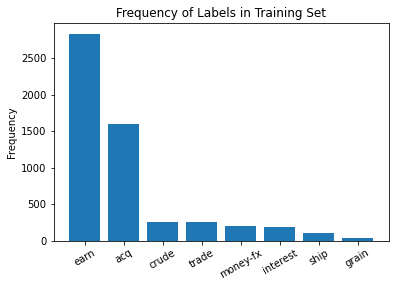

In [26]:
val_counts = train_data[0].value_counts()
plt.bar(val_counts.index, val_counts)
plt.xticks(rotation=30)
plt.title("Frequency of Labels in Training Set")
plt.ylabel("Frequency")
plt.show()

In [27]:
train_data.to_numpy()[0][1]

'champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter '

In [49]:
class TextLevelGNNDatasetClass: # This class is used to achieve parameters sharing among datasets
    def __init__(self, train_filename, test_filename, tokenizer, MAX_LENGTH=10, p=2, min_freq=2, train_validation_split=0.8):
        self.train_filename = train_filename
        self.test_filename = test_filename
        self.tokenizer = tokenizer
        self.MAX_LENGTH = MAX_LENGTH # The max length of each document to be processed
        self.p = p # the window size
        self.min_freq = min_freq # The minimum no. of occurrence for a word to be considered as a meaningful word. Words with less than this occurrence will be mapped to a globally shared embedding weight (to the <unk> token). It corresponds to the parameter k in the original paper
        self.train_validation_split = train_validation_split

        # read the training data
        self.train_data = pd.read_csv(self.train_filename, sep='\t', header=None)
        self.test_data = pd.read_csv(self.test_filename, sep='\t', header=None)

        # this class has its own stoi and itos class which contains just the vocab in the training data
        # and does NOT include the vocab in the validation data
        # the first two values are the unknown and the pad
        self.stoi = {'<unk>': 0, '<pad>': 1} # Re-index
        self.itos = {0: '<unk>', 1: '<pad>'} # Re-index
        self.vocab_count = len(self.stoi)
        self.embedding_matrix = None
        
        # create a dictionary mapping labels to their one-hot encoded values
        self.label_dict = dict(zip(self.train_data[0].unique(), pd.get_dummies(self.train_data[0].unique()).values.tolist()))

        # split training data in to training and validation data
        self.train_dataset, self.validation_dataset = random_split(self.train_data.to_numpy(), [int(len(self.train_data) * train_validation_split), len(self.train_data) - int(len(self.train_data) * train_validation_split)])
        self.test_dataset = self.test_data.to_numpy()

        # Based on train_dataset only. Updates self.stoi, self.itos, self.vocab_count and self.embedding_matrix
        self.build_vocab() 
        
        # this prepares the dataset
        self.train_dataset, self.validation_dataset, self.test_dataset, self.edge_stat, self.public_edge_mask = self.prepare_dataset()

    def build_vocab(self):
        # getting list of all tokens
        vocab_list = [re.findall(r"[\w']+|[.,!?;]", sentence) for _, sentence in self.train_dataset]
        unique_vocab = []
        for vocab in vocab_list:
            unique_vocab.extend(vocab)
        # getting list of unique tokens
        unique_vocab = [item.lower() for item in list(set(unique_vocab))]
        for vocab in unique_vocab:
            # converting the vocab word to lower case since the tokenizer does not recognize upper case
            # if the vocab word is recognized by the tokenizer, add the vocab to stoi, itos, and increment vocab_count by 1
            if vocab in self.tokenizer.stoi.keys():
                # only add the vocab to the stoi keys and increment the vocab_count if the vocab isn't already in stoi
                if vocab not in stoi.keys():
                    self.stoi[vocab] = self.vocab_count
                    self.itos[self.vocab_count] = vocab
                    self.vocab_count += 1
        # getting the embedding matrix for all strings in the vocabulary
        self.embedding_matrix = self.tokenizer.embedding(self.tokenizer.encode(list(self.stoi.keys())))

    def prepare_dataset(self): # will also build self.edge_stat and self.public_edge_mask
        # preparing self.train_dataset
        # gets the first MAX_LENGTH words from each sentence in train_dataset and converts them to ints
        node_sets = [[self.stoi.get(vocab, 0) for vocab in re.findall(r"[\w']+|[.,!?;]", sentence)][:self.MAX_LENGTH] for _, sentence in self.train_dataset] # Only retrieve the first MAX_LENGTH words in each document
        # This function iterates through the nodeset and creates a neighborset which connects each node to the other nodes that are within the window of size p
        neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
        # gets the one-hot encoding of the labels
        labels = [self.label_dict[label] for label, _ in self.train_dataset]

        # Construct edge statistics and public edge mask
        edge_stat, public_edge_mask = self.build_public_edge_mask(node_sets, neighbor_sets, min_freq=self.min_freq)
        
        train_dataset = TextLevelGNNDataset(node_sets, neighbor_sets, public_edge_mask, labels)

        # preparing self.validation_dataset
        node_sets = [[self.stoi.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence in self.validation_dataset] # Only retrieve the first MAX_LENGTH words in each document
        neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
        labels = [self.label_dict[label] for label, _ in self.validation_dataset]
        validation_dataset = TextLevelGNNDataset(node_sets, neighbor_sets, public_edge_mask, labels)

        # preparing self.test_dataset
        node_sets = [[self.stoi.get(vocab, 0) for vocab in sentence.strip().split(' ')][:self.MAX_LENGTH] for _, sentence in self.test_dataset] # Only retrieve the first MAX_LENGTH words in each document
        neighbor_sets = [create_neighbor_set(node_set, p=self.p) for node_set in node_sets]
        labels = [self.label_dict[label] for label, _ in self.test_dataset]
        test_dataset = TextLevelGNNDataset(node_sets, neighbor_sets, public_edge_mask, labels)

        return train_dataset, validation_dataset, test_dataset, edge_stat, public_edge_mask

    def build_public_edge_mask_new(self, node_sets, neighbor_sets, min_freq=2):
        # edge_stat is a torch.tensor that measures the edges of all vocab tokens with all other vocab tokens
        edge_stat = torch.zeros(self.vocab_count, self.vocab_count)
        for neighbor_set in neighbor_sets:
            for neighbor in neighbor_set:
                for to_node in neighbor:
                    # all of the rows in node_set and in column to_node are increased by 1
                    # create neighbors_temp which removes one single occurrence of to_node,
                    # that way the edges only connect the same node with itself if it shows up multiple times in neighbor
                    neighbors_temp = copy.deepcopy(neighbor)
                    neighbors_temp.remove(to_node)
                    # connect all neighbors to the node
                    edge_stat[neighbors_temp, to_node] += 1
                    # connect all nodes to the neighbors
                    edge_stat[to_node, neighbors_temp] += 1
        public_edge_mask = edge_stat < min_freq # mark True at uncommon edges
        return edge_stat, public_edge_mask

    def build_public_edge_mask(self, node_sets, neighbor_sets, min_freq=2):
        # edge_stat is a torch.tensor that measures the edges of all vocab tokens with all other vocab tokens
        edge_stat = torch.zeros(self.vocab_count, self.vocab_count)
        for node_set, neighbor_set in zip(node_sets, neighbor_sets):
            for neighbor in neighbor_set:
                for to_node in neighbor:
                    # all of the rows in node_set and in column to_node are increased by 1
                    edge_stat[node_set, to_node] += 1
        public_edge_mask = edge_stat < min_freq # mark True at uncommon edges
        return edge_stat, public_edge_mask

## Instantiating train, validation, and test dataset

In [29]:
class TextLevelGNNDataset(Dataset): # For instantiating train, validation and test dataset
    def __init__(self, node_sets, neighbor_sets, public_edge_mask, labels):
        super(TextLevelGNNDataset).__init__()
        self.node_sets = node_sets
        self.neighbor_sets = neighbor_sets
        self.public_edge_mask = public_edge_mask
        self.labels = labels

    def __getitem__(self, i):
        return torch.LongTensor(self.node_sets[i]), \
               torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1), \
               self.public_edge_mask[torch.LongTensor(self.node_sets[i]).unsqueeze(-1).repeat(1, torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1).shape[-1]), torch.nn.utils.rnn.pad_sequence([torch.LongTensor(neighbor) for neighbor in self.neighbor_sets[i]], batch_first=True, padding_value=1)], \
               torch.FloatTensor(self.labels[i])

    def __len__(self):
        return len(self.labels)

## Create Neighbor Set Function
This function iterates through the nodeset and creates a neighborset which connects each node to the other nodes that are within the window of size p.

In [30]:
def create_neighbor_set(node_set, p=2):
    if type(node_set[0]) != int:
        raise ValueError('node_set should be a 1D list!')
    if p < 0:
        raise ValueError('p should be an integer >= 0!')
    sequence_length = len(node_set)
    neighbor_set = []
    for i in range(sequence_length):
        neighbor = []
        for j in range(-p, p+1):
            if 0 <= i + j < sequence_length:
                neighbor.append(node_set[i+j])
        neighbor_set.append(neighbor)
    return neighbor_set
# example:
# single_nodeset = [8145, 15469, 446, 6223, 5523, 4492, 8145, 11493, 11578, 9559]
# create_neighbor_set(single_nodeset)

## Padding Sequences and Tensors Functions

In [31]:
def pad_custom_sequence(sequences):
    '''
    To pad different sequences into a padded tensor for training. The main purpose of this function is to separate different sequence, pad them in different ways and return padded sequences.
    Input:
        sequences <list>: A sequence with a length of 4, representing the node sets sequence in index 0, neighbor sets sequence in index 1, public edge mask sequence in index 2 and label sequence in index 3.
                          And the length of each sequences are same as the batch size.
                          sequences: [node_sets_sequence, neighbor_sets_sequence, public_edge_mask_sequence, label_sequence]
    Return:
        node_sets_sequence <torch.LongTensor>: The padded node sets sequence (works with batch_size >= 1).
        neighbor_sets_sequence <torch.LongTensor>: The padded neighbor sets sequence (works with batch_size >= 1).
        public_edge_mask_sequence <torch.BoolTensor>: The padded public edge mask sequence (works with batch_size >= 1).
        label_sequence <torch.FloatTensor>: The padded label sequence (works with batch_size >= 1).
    '''
    node_sets_sequence = []
    neighbor_sets_sequence = []
    public_edge_mask_sequence = []
    label_sequence = []
    for node_sets, neighbor_sets, public_edge_mask, label in sequences:
        node_sets_sequence.append(node_sets)
        neighbor_sets_sequence.append(neighbor_sets)
        public_edge_mask_sequence.append(public_edge_mask)
        label_sequence.append(label)
    node_sets_sequence = torch.nn.utils.rnn.pad_sequence(node_sets_sequence, batch_first=True, padding_value=1)
    neighbor_sets_sequence, _ = padding_tensor(neighbor_sets_sequence)
    public_edge_mask_sequence, _ = padding_tensor(public_edge_mask_sequence)
    label_sequence = torch.nn.utils.rnn.pad_sequence(label_sequence, batch_first=True, padding_value=1)
    return node_sets_sequence, neighbor_sets_sequence, public_edge_mask_sequence, label_sequence


In [32]:
def padding_tensor(sequences, padding_idx=1):
    '''
    To pad tensor of different shape to be of the same shape, i.e. padding [tensor.rand(2, 3), tensor.rand(3, 5)] to a shape (2, 3, 5), where 0th dimension is batch_size, 1st and 2nd dimensions are padded.
    Input:
        sequences <list>: A list of tensors
        padding_idx <int>: The index that corresponds to the padding index
    Return:
        out_tensor <torch.tensor>: The padded tensor
        mask <torch.tensor>: A boolean torch tensor where 1 (represents '<pad>') are marked as true
    '''
    num = len(sequences)
    max_len_0 = max([s.shape[0] for s in sequences])
    max_len_1 = max([s.shape[1] for s in sequences])
    out_dims = (num, max_len_0, max_len_1)
    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_idx)
    for i, tensor in enumerate(sequences):
        len_0 = tensor.size(0)
        len_1 = tensor.size(1)
        out_tensor[i, :len_0, :len_1] = tensor
    mask = out_tensor == padding_idx # Marking all places with padding_idx as mask
    return out_tensor, mask

# Message Passing Function

In [33]:
class MessagePassing(nn.Module):
    def __init__(self, vertice_count, input_size, out_size, dropout_rate=0, padding_idx=1):
        super(MessagePassing, self).__init__()
        self.vertice_count = vertice_count # |V|
        self.input_size = input_size # d
        self.out_size = out_size # c
        self.dropout_rate = dropout_rate
        self.padding_idx = padding_idx
        self.information_rate = nn.Parameter(torch.rand(self.vertice_count, 1)) # (|V|, 1), which means it is a column vector
        self.linear = nn.Linear(self.input_size, self.out_size) # (d, c)
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, node_sets, embedded_node, edge_weight, embedded_neighbor_node):
        # node_sets: (batch_size, l)
        # embedded_node: (batch_size, l, d)
        # edge_weight: (batch_size, max_sentence_length, max_neighbor_count)
        # embedded_neighbor_node: (batch_size, max_sentence_length, max_neighbor_count, d)

        tmp_tensor = (edge_weight.view(-1, 1) * embedded_neighbor_node.view(-1, self.input_size)).view(embedded_neighbor_node.shape) # (batch_size, max_sentence_length, max_neighbor_count, d)
        tmp_tensor = tmp_tensor.masked_fill(tmp_tensor == 0, -1e18) # (batch_size, max_sentence_length, max_neighbor_count, d), mask for M such that masked places are marked as -1e18
        tmp_tensor = self.dropout(tmp_tensor)
        M = tmp_tensor.max(dim=2)[0] # (batch_size, max_sentence_length, d), which is same shape as embedded_node (batch_size, l, d)
        information_rate = self.information_rate[node_sets] # (batch_size, l, 1)
        information_rate = information_rate.masked_fill((node_sets == self.padding_idx).unsqueeze(-1), 1) # (batch_size, l, 1), Fill the information rate of the padding index as 1, such that new e_n = (1-i_r) * M + i_r * e_n = (1-1) * 0 + 1 * e_n = e_n (no update)
        embedded_node = (1 - information_rate) * M + information_rate * embedded_node # (batch_size, l, d)
        sum_embedded_node = embedded_node.sum(dim=1) # (batch_size, d)
        x = F.relu(self.linear(sum_embedded_node)) # (batch_size, c)
#         x = self.dropout(x) # if putting dropout with p=0.5 here, it is equivalent to wiping 4 choices out of 8 choices on the question sheet, which does not make sense. If a dropout layer is placed at here, it works the best when p=0 (disabled), followed by p=0.05, ..., p=0.5 (worst and does not even converge).
        y = F.softmax(x, dim=1) # (batch_size, c) along the c dimension
        return y

## Building the GNN Function

In [34]:
class TextLevelGNN(nn.Module):
    def __init__(self, pretrained_embeddings, out_size=8, dropout_rate=0, padding_idx=1):
        super(TextLevelGNN, self).__init__()
        self.out_size = out_size # c
        self.padding_idx = padding_idx
        self.weight_matrix = nn.Parameter(torch.randn(pretrained_embeddings.shape[0], pretrained_embeddings.shape[0])) # (|V|, |V|)        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False, padding_idx=self.padding_idx) # (|V|, d)
        self.message_passing = MessagePassing(vertice_count=pretrained_embeddings.shape[0], input_size=pretrained_embeddings.shape[1], out_size=self.out_size, dropout_rate=dropout_rate, padding_idx=self.padding_idx) # input_size: (d,); out_size: (c,)
        self.public_edge_weight = nn.Parameter(torch.randn(1, 1)) # (1, 1)

    def forward(self, node_sets, neighbor_sets, public_edge_mask):
        # node_sets: (batch_size, l)
        # neighbor_sets: (batch_size, max_sentence_length, max_neighbor_count)
        # neighbor_sets_mask: (batch_size, max_sentence_length, max_neighbor_count) (no need)
        # public_edge_mask: (batch_size, max_sentence_length, max_neighbor_count)

        embedded_node = self.embedding(node_sets) # (batch_size, l, d)
        edge_weight = model.weight_matrix[node_sets.unsqueeze(2).repeat(1, 1, neighbor_sets.shape[-1]), neighbor_sets] # (batch_size, max_sentence_length, max_neighbor_count), neighbor_sets.shape[-1]: eg p=2, this expression=5; p=3, this expression=7. This is to first make node_sets to have same shape with neighbor_sets, then just do 1 query instead of 32*100 queries to speed up performance
        a = edge_weight * ~public_edge_mask # (batch_size, max_sentence_length, max_neighbor_count)
        b = self.public_edge_weight.unsqueeze(2).expand(1, public_edge_mask.shape[-2], public_edge_mask.shape[-1]) * public_edge_mask # (batch_size, max_sentence_length, max_neighbor_count)
        edge_weight = a + b # (batch_size, max_sentence_length, max_neighbor_count)
        embedded_neighbor_node = self.embedding(neighbor_sets) # (batch_size, max_sentece_length, max_neighbor_count, d)

        # Apply mask to edge_weight, to mask and cut-off any relationships to the padding nodes
        edge_weight = edge_weight.masked_fill((node_sets.unsqueeze(2).repeat(1, 1, neighbor_sets.shape[-1]) == self.padding_idx) | (neighbor_sets == self.padding_idx), 0) # (batch_size, max_sentence_length, max_neighbor_count)
        x = self.message_passing(node_sets, embedded_node, edge_weight, embedded_neighbor_node) # (batch_size, c)
        return x

## Setting up Arguments

In [85]:
args = {'cuda':'0',
       'embedding_size':300,
       'p':3,
       'min_freq':2,
       'max_length':70,
       'dropout':0,
       'lr':1e-3,
       'lr_decay_factor':0.9,
       'lr_decay_every':5,
       'weight_decay':1e-4,
       'early_stopping_patience':10,
       'early_stopping_criteria':'loss',
       'epoch':300}

In [86]:
# converting args to series so they can be referenced the same way that argparse.ArgumentParser()
# is reference in running a python script in the terminal
args = pd.Series(data=[args[key] for key in args],index=[key for key in args.keys()])

# Main AI

In [87]:
#creating tokenizer
tokenizer = GloveTokenizer(f'embeddings/glove.6B.{args.embedding_size}d.txt')

In [50]:
# creating train_loader, validation_loader, and test_loader
dataset = TextLevelGNNDatasetClass(train_filename='r8-train-all-terms.txt',
                                   test_filename='r8-test-all-terms.txt',
                                   train_validation_split=0.8,
                                   tokenizer=tokenizer,
                                   p=args.p,
                                   min_freq=args.min_freq,
                                   MAX_LENGTH=args.max_length)

train_loader = DataLoader(dataset.train_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)
validation_loader = DataLoader(dataset.validation_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)
test_loader = DataLoader(dataset.test_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence)

In [51]:
# setting device to cuda if gpu is available
device = torch.device(f'cuda:{args.cuda}') if torch.cuda.is_available() else torch.device('cpu')

In [52]:
# building model
model = TextLevelGNN(pretrained_embeddings=torch.tensor(dataset.embedding_matrix), dropout_rate=args.dropout).to(device)

In [53]:
# setting training parameters
criterion = nn.BCELoss()

lr = args.lr
lr_decay_factor = args.lr_decay_factor
lr_decay_every = args.lr_decay_every
weight_decay = args.weight_decay

early_stopping_patience = args.early_stopping_patience
early_stopping_criteria = args.early_stopping_criteria
best_epoch = 0 # Initialize

training = {}
validation = {}
testing = {}
training['accuracy'] = []
training['loss'] = []
validation['accuracy'] = []
validation['loss'] = []
testing['accuracy'] = []
testing['loss'] = []

print(args)

cuda                            0
embedding_size                300
p                               3
min_freq                        2
max_length                     70
dropout                         0
lr                          0.001
lr_decay_factor               0.9
lr_decay_every                  5
weight_decay               0.0001
warm_up_epoch                   0
early_stopping_patience        10
early_stopping_criteria      loss
epoch                         300
dtype: object


## Training the Model

In [54]:
for epoch in range(args.epoch):
    model.train()
    train_loss = 0
    train_correct_items = 0
    previous_epoch_timestamp = time()

    if epoch % lr_decay_every == 0: # Update optimizer for every lr_decay_every epochs
        if epoch != 0: # When it is the first epoch, disable the lr_decay_factor
            lr *= lr_decay_factor
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(train_loader):
        node_sets = node_sets.to(device)
        neighbor_sets = neighbor_sets.to(device)
        public_edge_masks = public_edge_masks.to(device)
        labels = labels.to(device)
        # make the predictions
        prediction = model(node_sets, neighbor_sets, public_edge_masks)
        # calculate loss
        loss = criterion(prediction, labels).to(device)
        # explicitly setting the gradients to zero before starting backpropogation
        # because PyTorch accumulates the gradients on subsequent backward passes
        # so the gradients need to be zeroed out, otherwise, the gradient would be a combination of the old
        # gradient, which was already used to update the model parameters, and the newly computed gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    train_accuracy = train_correct_items / len(dataset.train_dataset)

    model.eval()
    validation_loss = 0
    validation_correct_items = 0
    for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(validation_loader):
        node_sets = node_sets.to(device)
        neighbor_sets = neighbor_sets.to(device)
        public_edge_masks = public_edge_masks.to(device)
        labels = labels.to(device)
        prediction = model(node_sets, neighbor_sets, public_edge_masks)
        loss = criterion(prediction, labels).to(device)
        validation_loss += loss.item()
        validation_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    validation_accuracy = validation_correct_items / len(dataset.validation_dataset)

#     model.eval()
    test_loss = 0
    test_correct_items = 0
    for i, (node_sets, neighbor_sets, public_edge_masks, labels) in enumerate(test_loader):
        node_sets = node_sets.to(device)
        neighbor_sets = neighbor_sets.to(device)
        public_edge_masks = public_edge_masks.to(device)
        labels = labels.to(device)
        prediction = model(node_sets, neighbor_sets, public_edge_masks)
        loss = criterion(prediction, labels).to(device)
        test_loss += loss.item()
        test_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    test_accuracy = test_correct_items / len(dataset.test_dataset)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Testing Loss: {test_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}, Time Used: {time()-previous_epoch_timestamp:.2f}s')
    training['accuracy'].append(train_accuracy)
    training['loss'].append(train_loss)
    validation['accuracy'].append(validation_accuracy)
    validation['loss'].append(validation_loss)
    testing['accuracy'].append(test_accuracy)
    testing['loss'].append(test_loss)

Epoch: 1, Training Loss: 55.4425, Validation Loss: 13.1873, Testing Loss: 25.9972, Training Accuracy: 0.2826, Validation Accuracy: 0.2789, Testing Accuracy: 0.3175, Time Used: 9.48s
Epoch: 2, Training Loss: 51.9937, Validation Loss: 13.1874, Testing Loss: 25.9974, Training Accuracy: 0.2940, Validation Accuracy: 0.2789, Testing Accuracy: 0.3175, Time Used: 9.02s
Epoch: 3, Training Loss: 51.9943, Validation Loss: 13.1851, Testing Loss: 25.9977, Training Accuracy: 0.2938, Validation Accuracy: 0.2799, Testing Accuracy: 0.3175, Time Used: 9.01s
Epoch: 4, Training Loss: 51.9468, Validation Loss: 13.1595, Testing Loss: 25.8962, Training Accuracy: 0.2963, Validation Accuracy: 0.2835, Testing Accuracy: 0.3234, Time Used: 9.01s
Epoch: 5, Training Loss: 51.3057, Validation Loss: 13.0183, Testing Loss: 25.6247, Training Accuracy: 0.3191, Validation Accuracy: 0.3008, Testing Accuracy: 0.3335, Time Used: 9.03s
Epoch: 6, Training Loss: 26.0781, Validation Loss: 4.5329, Testing Loss: 9.0667, Training 

In [58]:
df = pd.concat([pd.DataFrame(training), pd.DataFrame(validation), pd.DataFrame(testing)], axis=1)
df.columns = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 'Testing Accuracy', 'Testing Loss']
df.to_csv(f'embedding_size={args.embedding_size},p={args.p},min_freq={args.min_freq},max_length={args.max_length},dropout={args.dropout},lr={args.lr},lr_decay_factor={args.lr_decay_factor},lr_decay_every={args.lr_decay_every},weight_decay={args.weight_decay},early_stopping_patience={args.early_stopping_patience},early_stopping_criteria={args.early_stopping_criteria},epoch={args.epoch}.csv') # Logging

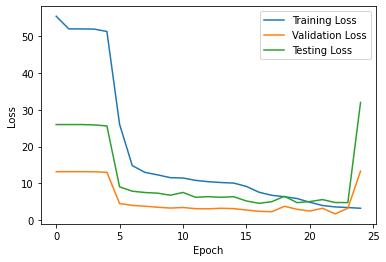

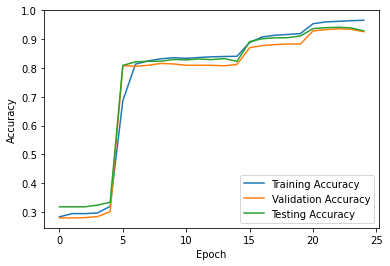

In [59]:
import matplotlib.pyplot as plt

plt.plot(training['loss'], label='Training Loss')
plt.plot(validation['loss'], label='Validation Loss')
plt.plot(testing['loss'], label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(training['accuracy'], label='Training Accuracy')
plt.plot(validation['accuracy'], label='Validation Accuracy')
plt.plot(testing['accuracy'], label='Testing Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Comparison with LSTM

In [150]:
class TextLevelNLPDatasetClass: # This class is used to achieve parameters sharing among datasets
    def __init__(self, train_filename, test_filename, tokenizer, MAX_LENGTH=10, p=2, min_freq=2, train_validation_split=0.8):
        print("Initializing TextLevelNLPDatasetClass")
        self.train_filename = train_filename
        self.test_filename = test_filename
        self.tokenizer = tokenizer
        self.MAX_LENGTH = MAX_LENGTH
        #self.p = p
        #self.min_freq = min_freq
        self.train_validation_split = train_validation_split

        self.train_data = pd.read_csv(self.train_filename, sep='\t', header=None)
        self.test_data = pd.read_csv(self.test_filename, sep='\t', header=None)

        self.stoi = {'<unk>': 0, '<pad>': 1} # Re-index
        self.itos = {0: '<unk>', 1: '<pad>'} # Re-index
        self.vocab_count = len(self.stoi)
        self.embedding_matrix = None
        self.label_dict = dict(zip(self.train_data[0].unique(), pd.get_dummies(self.train_data[0].unique()).values.tolist()))

        self.train_dataset, self.validation_dataset = random_split(self.train_data.to_numpy(), [int(len(self.train_data) * train_validation_split), len(self.train_data) - int(len(self.train_data) * train_validation_split)])
        self.test_dataset = self.test_data.to_numpy()

        self.build_vocab() # Based on train_dataset only. Updates self.stoi, self.itos, self.vocab_count and self.embedding_matrix

        self.train_dataset, self.validation_dataset, self.test_dataset = self.prepare_dataset()

    def build_vocab(self):
        print("Building Vocab")
        vocab_list = [sentence.split(' ') for _, sentence in self.train_dataset]
        unique_vocab = []
        for vocab in vocab_list:
            unique_vocab.extend(vocab)
        unique_vocab = list(set(unique_vocab))
        for vocab in unique_vocab:
            if vocab in self.tokenizer.stoi.keys():
                self.stoi[vocab] = self.vocab_count
                self.itos[self.vocab_count] = vocab
                self.vocab_count += 1
        self.embedding_matrix = self.tokenizer.embedding(self.tokenizer.encode(list(self.stoi.keys())))

    def prepare_dataset(self): # will also build self.edge_stat and self.public_edge_mask
        print("Preparing Dataset")
        # preparing self.train_dataset
        # converting labels to data and converting words to numbers
        labels = [self.label_dict[label] for label, _ in self.train_dataset]
        train_data_encoded = [[self.stoi.get(vocab, 0) for vocab in re.findall(r"[\w']+|[.,!?;]", sentence)][:self.MAX_LENGTH] for _, sentence in self.train_dataset]
        train_dataset = TextLevelNLPDataset(train_data_encoded, labels)

        # preparing self.validation_dataset
        labels = [self.label_dict[label] for label, _ in self.validation_dataset]
        val_data_encoded = [[self.stoi.get(vocab, 0) for vocab in re.findall(r"[\w']+|[.,!?;]", sentence)][:self.MAX_LENGTH] for _, sentence in self.validation_dataset]
        validation_dataset = TextLevelNLPDataset(val_data_encoded, labels)

        # preparing self.test_dataset
        labels = [self.label_dict[label] for label, _ in self.test_dataset]
        test_data_encoded = [[self.stoi.get(vocab, 0) for vocab in re.findall(r"[\w']+|[.,!?;]", sentence)][:self.MAX_LENGTH] for _, sentence in self.test_dataset]
        test_dataset = TextLevelNLPDataset(test_data_encoded, labels)

        return train_dataset, validation_dataset, test_dataset
    

In [124]:
train_data = pd.read_csv(train_filename, sep='\t', header=None)

In [125]:
label_dict = dict(zip(train_data[0].unique(), pd.get_dummies(train_data[0].unique()).values.tolist()))

In [130]:
train_validation_split = 0.8
train_dataset, validation_dataset = random_split(train_data.to_numpy(), [int(len(train_data) * train_validation_split), len(train_data) - int(len(train_data) * train_validation_split)])
test_dataset = test_data.to_numpy()

In [133]:
labels = [label_dict[label] for label, _ in train_dataset]

In [137]:
stoi = {'<unk>': 0, '<pad>': 1} # Re-index
itos = {0: '<unk>', 1: '<pad>'} # Re-index
vocab_count = len(stoi)

In [138]:
print("Building Vocab")
vocab_list = [sentence.split(' ') for _, sentence in train_dataset]
unique_vocab = []
for vocab in vocab_list:
    unique_vocab.extend(vocab)
unique_vocab = list(set(unique_vocab))
for vocab in unique_vocab:
    if vocab in tokenizer.stoi.keys():
        stoi[vocab] = vocab_count
        itos[vocab_count] = vocab
        vocab_count += 1
embedding_matrix = tokenizer.embedding(tokenizer.encode(list(stoi.keys())))

Building Vocab


In [139]:
MAX_LENGTH = 20

In [140]:
train_xyz = [[stoi.get(vocab, 0) for vocab in re.findall(r"[\w']+|[.,!?;]", sentence)][:MAX_LENGTH] for _, sentence in train_dataset]

In [142]:
train_xyz[0]

[2807,
 9735,
 52,
 3943,
 9886,
 11728,
 2807,
 5399,
 10430,
 7464,
 1761,
 6515,
 8197,
 2807,
 5399,
 10430,
 7464,
 4689,
 2863,
 14383]

In [296]:
class TextLevelNLPDataset(Dataset): # For instantiating train, validation and test dataset
    def __init__(self, train_data, labels):
        super(TextLevelGNNDataset).__init__()
        print("Initializing TextLevelNLPDataset")
        self.train_data = train_data
        self.labels = labels

    def __getitem__(self, i):
        return torch.LongTensor(self.train_data[i]), torch.IntTensor(self.labels[i])

    def __len__(self):
        return len(self.labels)

In [297]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class TextLevelLSTM(nn.Module):
    def __init__(self, pretrained_embeddings, out_size=8, dropout_rate=0, padding_idx=1):
        super(TextLevelLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False) # (|V|, d)
        self.dimension = 10
        self.lstm = nn.LSTM(input_size=20,
                           hidden_size=self.dimension,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.fc = nn.Linear(2*self.dimension, 1)
        
    def forward(self, text, text_len=10):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out        

In [298]:
def padding_tensor(sequences, padding_idx=1):
    '''
    To pad tensor of different shape to be of the same shape, i.e. padding [tensor.rand(2, 3), tensor.rand(3, 5)] to a shape (2, 3, 5), where 0th dimension is batch_size, 1st and 2nd dimensions are padded.
    Input:
        sequences <list>: A list of tensors
        padding_idx <int>: The index that corresponds to the padding index
    Return:
        out_tensor <torch.tensor>: The padded tensor
        mask <torch.tensor>: A boolean torch tensor where 1 (represents '<pad>') are marked as true
    '''
    num = len(sequences)
    max_len_0 = max([s.shape[0] for s in sequences])
    #max_len_1 = max([s.shape[1] for s in sequences])
    out_dims = (num, max_len_0)
    out_tensor = sequences[0].data.new(*out_dims).fill_(padding_idx)
    for i, tensor in enumerate(sequences):
        len_0 = tensor.size(0)
        #len_1 = tensor.size(1)
        out_tensor[i, :len_0] = tensor
    mask = out_tensor == padding_idx # Marking all places with padding_idx as mask
    return out_tensor, mask

In [299]:
def pad_custom_sequence_NLP(sequences):
    texts_sequence = []
    label_sequence = []
    
    for text_set, label_set in sequences:
        texts_sequence.append(text_set)
        label_sequence.append(label_set)
    #texts_sequence = torch.nn.utils.rnn.pad_sequence(texts_sequence, batch_first=True, padding_value=1)
    texts_sequence, _ = padding_tensor(texts_sequence)
    label_sequence, _ = padding_tensor(label_sequence)
    return texts_sequence, label_sequence

In [300]:
#tokenizer = GloveTokenizer(f'embeddings/glove.6B.300d.txt')

In [301]:
dataset = TextLevelNLPDatasetClass(train_filename='r8-train-all-terms.txt',
                                   test_filename='r8-test-all-terms.txt',
                                   train_validation_split=0.8,
                                   tokenizer=tokenizer,
                                   MAX_LENGTH=10)
train_loader = DataLoader(dataset.train_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence_NLP)
validation_loader = DataLoader(dataset.validation_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence_NLP)
test_loader = DataLoader(dataset.test_dataset, batch_size=32, shuffle=True, collate_fn=pad_custom_sequence_NLP)

Initializing TextLevelNLPDatasetClass
Building Vocab
Preparing Dataset
Initializing TextLevelNLPDataset
Initializing TextLevelNLPDataset
Initializing TextLevelNLPDataset


In [302]:
for ind, item in enumerate(dataset.train_dataset):
    #print(ind)
    if ind == 0:
        print(item)

    #print(len(item[0].numpy()))

(tensor([ 7058, 10837, 11294, 12527, 12669,  7332,  7979,  2337,  7979,  2251]), tensor([0, 0, 1, 0, 0, 0, 0, 0], dtype=torch.int32))


In [303]:
for ind, item in enumerate(train_loader):
    if ind == 1:
        print(item)

(tensor([[12665,  4788,  5978, 12155,  7773,  6987, 11428,  1766,  4250,  5427],
        [ 1862,  8008,     0, 13526, 11905,     0, 12676,  2251, 10323,  2251],
        [ 7442, 13314, 12866,  1589,  8654,  3969,     0,  7442, 13314,  9545],
        [  995,  7606, 11129, 12919, 14675,  8072,  7425,  1766,  6752,   867],
        [ 1246,  9465,  4766,  8153,  1592,  9713,  5008, 13513,  9545,  6539],
        [ 3594,  6512,  9545,  9638, 14955,  1668,  1129, 14564,  3371,     1],
        [ 4232,  6861, 15002, 13115, 14947,  4232,  6861,  9545,  9812,  8057],
        [11320, 13314, 13371, 11294,     0, 12669,  7332,  9548, 14980,  2337],
        [ 5966, 11294,     0,  3121, 10647,  3155,     0, 12676,  2251, 10323],
        [    0,  1783,  9433,  8646, 11496, 14980,  2337,  6978, 13401,  2251],
        [13643, 10505,  3760,  9545,  8795, 13526, 11905,     0, 12676,  2251],
        [ 4440, 12155,  8461,  6539, 11438,   263,  8798, 12738,     7, 13145],
        [ 2502,  2058, 15325, 13993,  2

In [304]:
device = torch.device(f'cuda:{args.cuda}') if torch.cuda.is_available() else torch.device('cpu')
model = TextLevelLSTM(pretrained_embeddings=torch.tensor(dataset.embedding_matrix), dropout_rate=0.5).to(device)
criterion = nn.BCELoss()

In [305]:
lr = args.lr
lr_decay_factor = args.lr_decay_factor
lr_decay_every = args.lr_decay_every
weight_decay = args.weight_decay

early_stopping_patience = args.early_stopping_patience
early_stopping_criteria = args.early_stopping_criteria
best_epoch = 0 # Initialize

training = {}
validation = {}
testing = {}
training['accuracy'] = []
training['loss'] = []
validation['accuracy'] = []
validation['loss'] = []
testing['accuracy'] = []
testing['loss'] = []

In [306]:
for epoch in range(args.epoch):
    model.train()
    train_loss = 0
    train_correct_items = 0
    previous_epoch_timestamp = time()

    if epoch % lr_decay_every == 0: # Update optimizer for every lr_decay_every epochs
        if epoch != 0: # When it is the first epoch, disable the lr_decay_factor
            lr *= lr_decay_factor
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    for i, (train_sets, labels) in enumerate(train_loader):
#         print('Finished batch:', i)
        train_sets = train_sets.to(device)
        labels = labels.to(device)
        prediction = model(train_sets)
        loss = criterion(prediction, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    train_accuracy = train_correct_items / len(dataset.train_dataset)

    model.eval()
    validation_loss = 0
    validation_correct_items = 0
    for i, (val_sets, labels) in enumerate(validation_loader):
        val_sets = val_sets.to(device)
        labels = labels.to(device)
        prediction = model(val_sets, public_edge_masks)
        loss = criterion(prediction, labels).to(device)
        validation_loss += loss.item()
        validation_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    validation_accuracy = validation_correct_items / len(dataset.validation_dataset)

#     model.eval()
    test_loss = 0
    test_correct_items = 0
    for i, (test_sets, labels) in enumerate(test_loader):
        test_sets = test_sets.to(device)
        labels = labels.to(device)
        prediction = model(node_sets, neighbor_sets, public_edge_masks)
        loss = criterion(prediction, labels).to(device)
        test_loss += loss.item()
        test_correct_items += (prediction.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
    test_accuracy = test_correct_items / len(dataset.test_dataset)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Testing Loss: {test_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, Testing Accuracy: {test_accuracy:.4f}, Time Used: {time()-previous_epoch_timestamp:.2f}s')
    training['accuracy'].append(train_accuracy)
    training['loss'].append(train_loss)
    validation['accuracy'].append(validation_accuracy)
    validation['loss'].append(validation_loss)
    testing['accuracy'].append(test_accuracy)
    testing['loss'].append(test_loss)


RuntimeError: 'lengths' argument should be a 1D CPU int64 tensor, but got 0D cpu Long tensor